In [112]:
import torch
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np

In [113]:
PATH_TO_FOLDER = r'/home/dingo/code/internship_projects/Internship_projects/instagram_influencer_image_classification/restructureddata'

In [114]:
import torchvision.transforms as tt

In [115]:
train_ds_tt = tt.Compose([tt.RandomGrayscale(p=0.3),tt.RandomHorizontalFlip(0.5),tt.RandomRotation(45),tt.ToTensor()])

In [116]:

dataset = ImageFolder(PATH_TO_FOLDER, train_ds_tt)
len(dataset)

139

In [117]:
train_ds, test_ds = random_split(dataset, [139,0])
train_dl = DataLoader(train_ds, 32)

In [118]:
import torch.nn as nn

In [119]:
class InstaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        nn.MaxPool2d(2,2), #output 16 x 64 x 64
        
        nn.Conv2d(16,32,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        
        nn.MaxPool2d(2,2), #output 32 x 32 x 32

        nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        
        nn.MaxPool2d(2,2), #output 64 x 16 x 16

        nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        
        nn.MaxPool2d(2,2), #output 128 x 8 x 8

        nn.Flatten(),
        nn.Linear(128*8*8, 512),
        nn.ReLU(),
        
        nn.Linear(512, 64),
        nn.ReLU(),
        nn.Linear(64,2)
    )
    def forward(self,x):
        out = self.network(x)
        return torch.softmax(out, dim=-1)

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [121]:
model = InstaModel().to(device)

In [122]:
model.parameters()

<generator object Module.parameters at 0x7f51694592a0>

In [123]:
opt_func = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_func = nn.BCELoss()

In [124]:
num_epochs = 1
for epoch in range(num_epochs):
  for images, labels in train_dl:
    images = images.to(device)
    pred = model(images)
    result = []
    for label in labels:
      z = np.zeros(2)
      z[int(label)] = 1
      result.append(z.astype(np.float32))
    result = torch.tensor(result)
    result = result.to(device)
    loss = loss_func(pred, result)
    loss.backward()
    opt_func.step()
    opt_func.zero_grad()
  prediction_arr = torch.argmax(pred, 1)
  result_arr = torch.argmax(result, 1)
  accuracy = torch.sum(prediction_arr == result_arr).item()/len(prediction_arr)
  print(f'Accuracy: {accuracy} in the epoch: {epoch+1} and loss: {loss}')

Accuracy: 0.45454545454545453 in the epoch: 1 and loss: 0.7066013216972351


In [125]:
torch.save(model, 'Insta.pth')

In [126]:
load_model = torch.load('Insta.pth')

In [127]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
def pred(path):
    q = path
    img = cv2.imread(q, 1)
    plt.imshow(img)
    img = cv2.resize(img, (128,128))
    img_arr = np.asarray(img).astype(np.float32)
    img_tensor = torch.Tensor(img_arr)
    img_tensor = img_tensor.permute(2,0,1)
    img_tensor = img_tensor.unsqueeze(0)
    pred = load_model(img_tensor)
    _, pred = torch.max(pred, dim=1)
    print(dataset.classes[pred[0].item()])

influencial


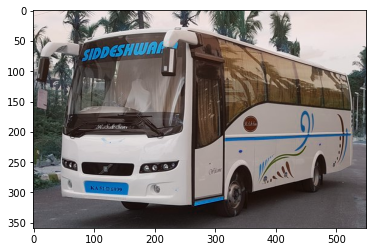

In [128]:
pred(r'/home/dingo/code/internship_projects/Internship_projects/instagram_influencer_image_classification/test/non_influencial/bus.png')